# Bilbao Exterior Buoy

In [1]:
# os
import os
import os.path as op
import sys

# arrays
import math
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.io import loadmat
from scipy import signal as sg

# plot
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join(os.getcwd()  , '..', '..', '..'))

# dependencies

if(os.path.isdir('waves-main')): #thebe
    os.chdir('waves-main')
from lib.eta_spec import *

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', np.RankWarning)

In [3]:
# path to buoy data
if(os.path.isdir('data')):
    p_data = op.abspath(op.join(os.getcwd(), 'data', 'Bilbao')) # thebe
else:
    p_data = op.abspath(op.join(os.getcwd(),'..', '..', '..', 'data', 'Bilbao')) # notebook

In [4]:
file = '2004_09-15.mat'
mat_file = loadmat(op.join(p_data, file))

### Load data

In [5]:
# open .mat files
'''
Metadata:
L      : 
deltaT : 
eta    :   Water level (mm)
north  : 
east   : 
Fecha  :   Matlab datenum
'''

python_datetime = [datetime.datetime.fromordinal(int(i)) + datetime.timedelta(days=i%1) - datetime.timedelta(days = 366) for i in mat_file['Fecha'][0]]
time = pd.to_datetime(python_datetime).round('H')
deltaT = np.unique(mat_file['deltaT'])[0]

# load water level series (mm)
watlev = mat_file['eta'] / 100
    

In [6]:
# select the first sea-state (17min)
seastate = '2005-03-31 04:00:00'
p = np.where(time == seastate)[0]
series = watlev[p,:][0]
time_series = pd.date_range(start=seastate, end=datetime.datetime.strptime(seastate, '%Y-%m-%d %H:%M:%S') + datetime.timedelta(seconds=1024), freq='S')[:1024]

## A.1 Observations

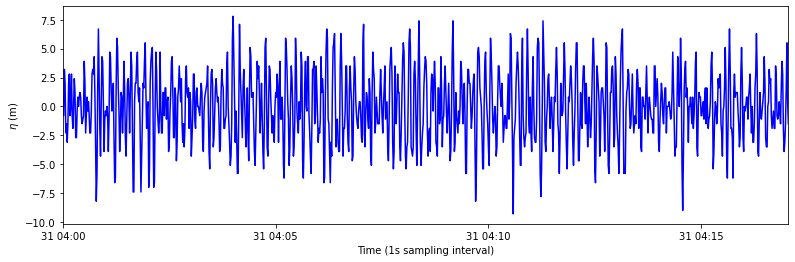

In [7]:
plt.figure(figsize=(13,4))
plt.plot(time_series, series, color='b')
plt.xlabel('Time (1s sampling interval)')
plt.ylabel('$\eta$ (m)')
plt.xlim([time_series[0], time_series[-1]])
plt.show()

In [8]:
print("Mean:              ", np.mean(series))
print("Standar Deviation: ", np.var(series))

Mean:               -0.0028320312499999795
Standar Deviation:  9.092345495223999


## A.2. Spectral Analysis

In [31]:
# Calculate spectra help(sg.welch)
f, E = sg.welch(series, fs = 1, nfft = 1024)

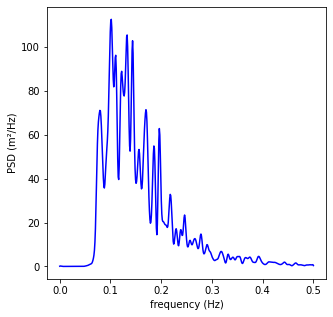

In [32]:
# Plot wave spectrum
plt.figure(figsize=(5,5))
plt.plot(f, E, c='b')
plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.show()

### Wave spectrum parameters

$$ m_{n} = \int_{0}^{\infty}S(\omega)d\omega   ; n=0,1,2... $$

$m_{0}:$ zeroth-order moment of the wave spectrum <br>
$m_{1}:$ first-order moment of the wave spectrum

In [11]:
# Momento calculado con el método calc_momento
print("Zeroth-order moment:  " + str(moment(0, f, E)))
print("First-order moment:   " + str(moment(1, f, E)))

Zeroth-order moment:  9.813944518280783
First-order moment:   1.538209247504411


<br>

$$ H_{m0} = 4.004 \sqrt{m_{0}} $$

In [12]:
# Wave height of the zeroth order moment
print("Wave heigh: " + str(4.004 * math.sqrt(moment(0, f, E))))


Wave heigh: 12.54341721940994


<br>

$$ \overline{\omega}=\frac{m_{1}}{m_{0}};\; \overline{T}=2\pi\frac{m_{0}}{m_{1}};\; \overline{T_{z}}=2\pi\frac{m_{0}}{m_{2}} $$

In [13]:
# Mean frequency
print("Mean frequency :                          " + str(moment(1, f, E)/moment(0, f, E)))

# Wave period associated to mean frequency
print("Wave period associated to mean frequency: " + str(moment(0, f, E)/moment(1, f, E)))

# Mean zero-crossing period
print("Mean zero-crossing period:                " + str(np.sqrt(moment(0, f, E)/moment(2, f, E))))


Mean frequency :                          0.15673710449851574
Wave period associated to mean frequency: 6.380110205554229
Mean zero-crossing period:                5.819286177281177


<br>

$$ \overline{T_{e}}=T_{-1}=2\pi\frac{m_{-1}}{m_{0}};\; 
v^{2}=\frac{m_{0}m_{2}}{m_{1}^{2}}-1 $$

In [14]:
# Mean energy period
print("Mean energy period: " + str(moment(-1, f, E)/moment(0, f, E)))

# Spectral width of Longuet-Higgins (1957)
# When de energy is concentrated in one single frequency, v = 0
print("Spectral width:     " + str((moment(0, f, E) * moment(2, f, E)/moment(1, f, E)**2)-1))

Mean energy period: 7.501600226207497
Spectral width:     0.2020344942391914


<br>

### JONSWAP Goda (1985)

$S(f)=\alpha\cdot H_{s}^{2} \cdot T_{p}^{-4} \cdot f^{-5} \cdot e^{-1.25 \cdot (T_{p} \cdot f)^{-4}} \cdot \gamma^{e^{-(T_{p} \cdot f - 1)^{2}/(2 \cdot \sigma^{2})}}$ 


$\alpha \approxeq \frac{0.0624}{0.230+0.0336 \cdot \gamma - 0.185 \cdot (1.9 + \gamma)^{-1}}$

$
\sigma=\begin{cases}
\sigma_{a};  f \leq f_{p} \\ \sigma_{b}; f \geq f_{p}
\end{cases}
$

$\gamma = 1 to 7 (mean 3.3), \sigma_{a}\approxeq0.07, \sigma_{b}\approxeq 0.09$

In [15]:
print('Peak frequency: ' + str(f[np.argmax(E)]))
print('Peak period:    ' + str(1/f[np.argmax(E)]))

Peak frequency: 0.1015625
Peak period:    9.846153846153847


In [16]:
gamma, EJon = assess_jonwsap(f, E)
print('Best gamma JONSWAP fit: ' + str(gamma))

Best gamma JONSWAP fit: 2


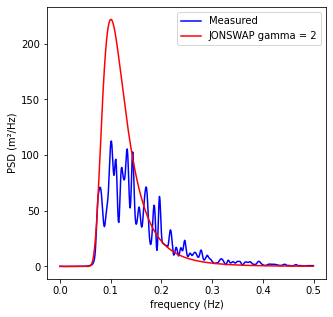

In [17]:
# Plot measured wave spectrum and theorecial JONSWAP shapes
plt.figure(figsize=(5,5))
plt.plot(f, E, c='b', label='Measured')
plt.plot(f[:-1], EJon, c='r', label='JONSWAP gamma = {0}'.format(gamma))

plt.xlabel('frequency (Hz)')
plt.ylabel('Densidad espectral (/Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.legend()
plt.show()

## A.3 Short-term statistics

Definition of ‘waves’ in a time record of the surface elevation with upward zero-crossings

In [22]:
fs = 1
T, H = upcrossing(series, fs)

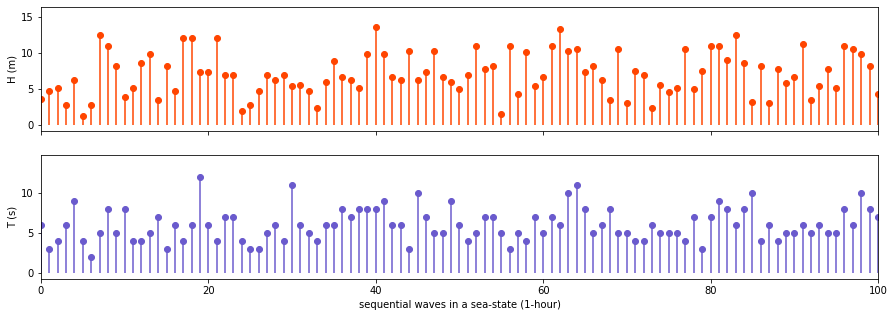

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(15,5), sharex=True)
axs[0].vlines(range(len(H)), np.full(len(H), 0), H, color='orangered')
axs[1].vlines(range(len(T)), np.full(len(T), 0), T, color='slateblue')
axs[0].scatter(range(len(H)), H, color='orangered')
axs[1].scatter(range(len(T)), T, color='slateblue')

axs[0].set_ylabel('H (m)')
axs[1].set_ylabel('T (s)')
axs[1].set_xlabel('sequential waves in a sea-state (1-hour)')

plt.xlim(0, 100)
plt.show()

### Statistical parameters

`mean wave heigh` $\overline H$

$\overline H = \frac{1}{N} \sum_{i=1}^{N} H_{i}$ <br> where i is the sequence number (in time) of the wave in the record

`root-mean-square wave height` $H_{rms}$

$H_{rms}=(\frac{1}{N} \sum_{i=1}^{N} H_{i}^{2})^{1/2}$

`significant wave heigh` $H_{1/3}$

$H_{1/3}=\frac{1}{N/3} \sum_{j=1}^{N/3} H_{j}$ <br> where j is the rank number of the wave, based on wave-heigh

`mean of the highest one-tenth of waves` $H_{1/10}$

$H_{1/10}=\frac{1}{N/10} \sum_{j=1}^{N/10} H_{j}$ 

`mean zero-crossing wave period` $\overline T_{0}$

$\overline T_{0}=\frac{1}{N} \sum_{i=1}^{N} T_{0,i}$

`significant wave period` $T_{1/3}$

$T_{1/3}=\frac{1}{N/3} \sum_{j=1}^{N/3} T_{0,j}$

In [24]:
# mean wave heigh
print("mean wave heigh:                        " + str(np.mean(H)))

# root-mean-square wave height
print("root-mean-square wave height:           " + str(rmsV(H)))

# significant wave heigh
print("significant wave heigh:                 " + str(highestN_stats(H, 3)))

# mean of the highest one-tenth of waves
print("mean of the highest one-tenth of waves: " + str(highestN_stats(H, 10)))

# maximun wave heigh
print("maximun wave heigh:                     " + str(np.max(H)))

# mean period
print("mean period:                            " + str(np.mean(T)))

# significant wave period
print("significant wave period:                " + str(highestN_stats(T, 3)))

# mean zero-crossing wave period
print("mean zero-crossing wave period:         " + str(highestN_stats(T, 10)))

# maximun wave period
print("maximun wave period:                    " + str(np.max(T)))

mean wave heigh:                        6.903592814371256
root-mean-square wave height:           10.743939187493275
significant wave heigh:                 10.770909090909093
mean of the highest one-tenth of waves: 12.7625
maximun wave heigh:                     15.600000000000001
mean period:                            6.017857142857146
significant wave period:                8.357142857142863
mean zero-crossing wave period:         10.312500000000014
maximun wave period:                    14.0


## Wave Heigh Distribution

In [25]:
# Rayleigh distribution of individual wave heighs
fHs = [4.01 * (i/(4 * math.sqrt(moment(0, f, E)))**2) * np.exp(-2.005 * (i**2/(4 * np.sqrt(moment(0, f, E)))**2)) for i in H]
FHs = [1 - np.exp(-2.005 * (i**2/(4 * np.sqrt(moment(0, f, E)))**2)) for i in H]

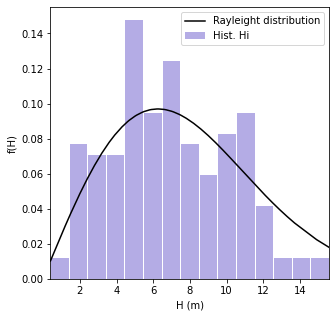

In [26]:
# Plot - sort arrays
plt.figure(figsize=(5,5))
plt.hist(H, density = True, bins = 15, rwidth=0.95, color = "slateblue", alpha=0.5, label='Hist. Hi')
plt.plot(np.sort(H), np.array(fHs)[np.array(H).argsort()], c = "k", zorder = 10, label='Rayleight distribution')

plt.xlabel('H (m)')
plt.ylabel('f(H)')
plt.legend()
plt.xlim(np.nanmin(H), np.nanmax(H))
plt.show()